Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [56]:
df=pd.read_csv("F:\\accenture_interview_project\\dataset\\peach_spectra_brix.csv")
df.head()

,Brix,wl1,wl2,wl3,wl4,wl5,wl6,wl7,wl8,wl9,...,wl591,wl592,wl593,wl594,wl595,wl596,wl597,wl598,wl599,wl600
0,15.5,-1.032355,-1.030551,-1.027970,-1.024937,-1.021866,-1.019143,-1.016866,-1.014910,-1.012907,...,0.692447,0.692944,0.692376,0.690764,0.688081,0.684294,0.679348,0.673240,0.665922,0.657307
1,16.7,-1.139034,-1.137186,-1.134485,-1.131222,-1.127761,-1.124464,-1.121508,-1.118802,-1.115973,...,0.729328,0.728031,0.725548,0.721815,0.716767,0.710405,0.702706,0.693710,0.683480,0.671960
2,18.1,-1.152821,-1.150937,-1.148288,-1.145165,-1.141951,-1.138977,-1.136366,-1.134011,-1.131516,...,0.736608,0.735214,0.732669,0.728911,0.723844,0.717415,0.709645,0.700555,0.690147,0.678390
3,14.8,-1.087215,-1.085455,-1.082867,-1.079797,-1.076568,-1.073632,-1.071087,-1.068877,-1.066654,...,0.758695,0.757963,0.756038,0.752903,0.748496,0.742886,0.736085,0.728019,0.718577,0.707702
4,15.1,-1.080364,-1.078436,-1.075784,-1.072693,-1.069562,-1.066691,-1.064214,-1.062025,-1.059787,...,0.719793,0.718875,0.716860,0.713771,0.709577,0.704232,0.697717,0.689882,0.680748,0.670263


Segregating X & Y values

In [57]:
x=df.drop(["Brix"],axis=1).values
y=df[["Brix"]].values
wl=np.arange(1,601)

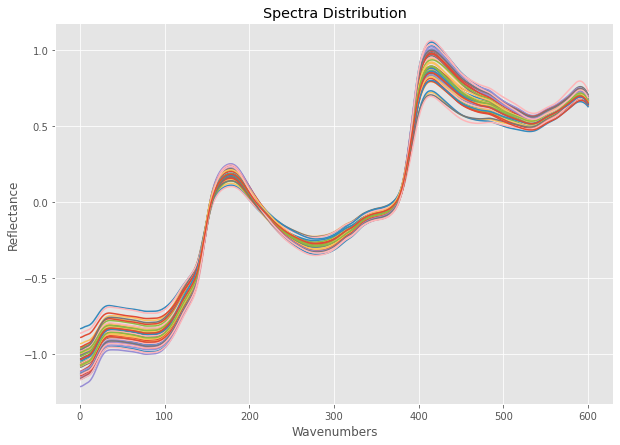

In [58]:
def plot_spectra(wavelength=wl,dataset=x,y_header="Value"):
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(10,7))
        plt.title("Spectra Distribution")
        plt.xlabel("Wavenumbers")
        plt.ylabel(y_header)
        plt.plot(wl,dataset.T)
        plt.show()

plot_spectra(wl,x,y_header="Reflectance")


Performing scatter correction techniques

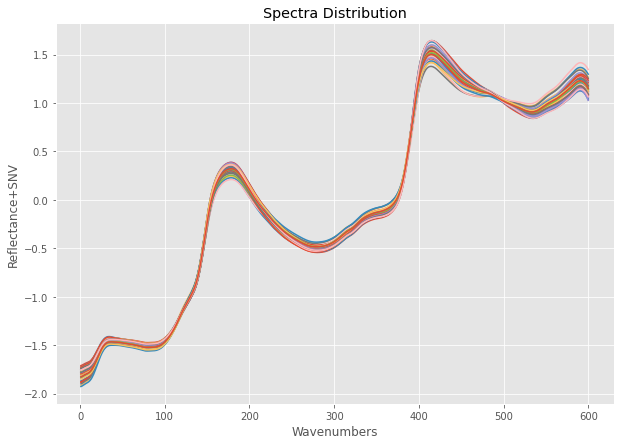

In [59]:
def SNV(dataset=x):
    output=np.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        output[i,:]=(dataset[i,:]-np.mean(dataset[i,:]))/np.std(dataset[i,:])
    return output

x_snv=SNV(x)
plot_spectra(wl,x_snv,y_header="Reflectance+SNV")

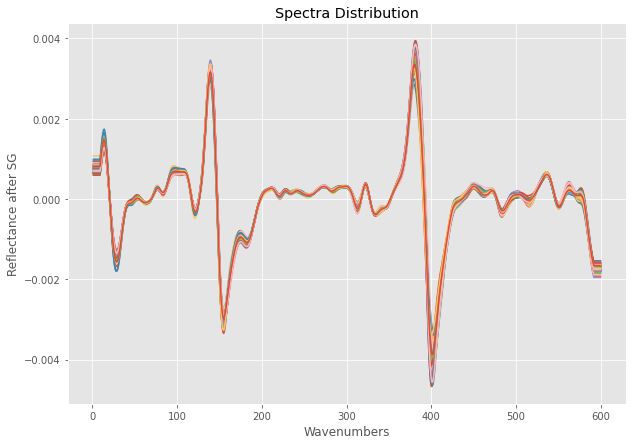

In [60]:
x_snv_sg=savgol_filter(x_snv,window_length=17,polyorder=2,deriv=2)
plot_spectra(wl,x_snv_sg,y_header="Reflectance after SG")

In [61]:
x_train,x_test,y_train,y_test=train_test_split(x_snv_sg,y,train_size=0.8)

In [62]:
model=PLSRegression(n_components=5,scale=True)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
acc=model.score(x_test,y_test)

print(f"RMSE value of the model is ==> {rmse}")
print(f"Accuracy of the model is ==> {acc}")

RMSE value of the model is ==> 1.5046626936520318
Accuracy of the model is ==> 0.5585348604500061


### Model Optimization

In [68]:
def optimize_model_performance(x_train_arr=x_train,y_train_arr=y_train,x_test_arr=x_test,y_test_arr=y_test,comp=20,plot_graph=True):
    rmse=[]
    n_comp=np.arange(1,comp+1)
    for i in n_comp:
        model=PLSRegression(n_components=i,scale=True)
        model.fit(x_train_arr,y_train_arr)
        y_pred=model.predict(x_test_arr)
        rmse_temp=np.sqrt(mean_squared_error(y_test_arr,y_pred))
        rmse.append(rmse_temp)

    sug_comp=np.argmin(rmse)
    print(f"Suggested number of components {sug_comp+1}")

    if(plot_graph):
        with plt.style.context(('ggplot')):
            plt.figure(figsize=(10,7))
            plt.title("RMSE vs components")
            plt.xlabel("No of components")
            plt.ylabel("RMSE value")
            plt.plot(n_comp,np.array(rmse),'-v',color="blue",mfc='blue')
            plt.show()

    final_model=PLSRegression(n_components=sug_comp+1,scale=True)
    final_model.fit(x_train_arr,y_train_arr)
    y_pred=model.predict(x_test_arr)
    rmse_final=np.sqrt(mean_squared_error(y_test_arr,y_pred))
    acc=final_model.score(x_test_arr,y_test_arr)
    if(plot_graph):
        with plt.style.context(('ggplot')):
            plt.figure(figsize=(10,7))
            plt.title("Actual vs Prediction")
            plt.plot(y_test_arr,label="Acutal Data")
            plt.plot(y_pred,label="Predicted Data")
            plt.legend()
        plt.show()

    joblib.dump(final_model,"model.pkl")
    print(f"The RMSE value with {sug_comp+1} no of components is {round(rmse_final,2)}")
    print(f"The accuracy of the model with {sug_comp+1} no of components is {round(acc,2)*100}%")
    


Suggested number of components 6


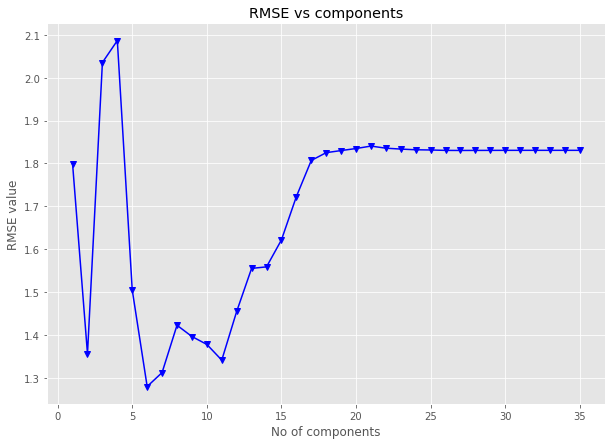

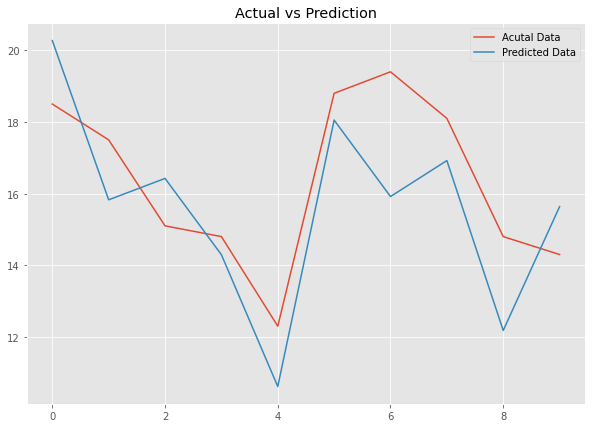

The RMSE value with 6 no of components is 1.83
The accuracy of the model with 6 no of components is 68.0%


In [69]:
optimize_model_performance(x_train,y_train,x_test,y_test,35,plot_graph=True)

### Joblib load & Testing

In [75]:
model=joblib.load("F:\\accenture_interview_project\\modelling_files\\model.pkl")
model.predict(x_test[0].reshape(-1,1).T)

array([[18.26687022]])

In [76]:
y_test[0]

array([18.5])